In [54]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [55]:
root_path = 'Microsoft_Stock_Price_Train_Test.csv'

In [56]:
stock_df = pd.read_csv(root_path)
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,80.738167,22483800
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,81.113907,26061400
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,81.827805,21912000
3,2018-01-05,87.660004,88.410004,87.430000,88.190002,82.842339,23407100
4,2018-01-08,88.199997,88.580002,87.599998,88.279999,82.926895,22113000


In [57]:
stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,adj_close,volume
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,80.738167,22483800
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,81.113907,26061400
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,81.827805,21912000
3,2018-01-05,87.660004,88.410004,87.430000,88.190002,82.842339,23407100
4,2018-01-08,88.199997,88.580002,87.599998,88.279999,82.926895,22113000


In [58]:
print("Total number of days: ",stock_df.shape[0])
print("Total number of fields: ",stock_df.shape[1])


Total number of days:  1278
Total number of fields:  7


## Checking NULL and NA Value

In [59]:
print("Null values:", stock_df.isnull().values.sum())

print("NA values:", stock_df.isna().values.any())

Null values: 0
NA values: False


## Convert date field into datetime format

In [60]:
stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [61]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1278 non-null   datetime64[ns, UTC]
 1   open       1278 non-null   float64            
 2   high       1278 non-null   float64            
 3   low        1278 non-null   float64            
 4   close      1278 non-null   float64            
 5   adj_close  1278 non-null   float64            
 6   volume     1278 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 70.0 KB


## Find the duration of dataset

In [62]:
print("Starting date: ",stock_df.iloc[0][0])

print("Ending date: ", stock_df.iloc[-1][0])

print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  2018-01-02 00:00:00+00:00
Ending date:  2023-01-30 00:00:00+00:00
Duration:  1854 days 00:00:00


## Prepare Stock Open Price
### Make seperate dataframe of Open price

In [63]:
stock_df_open = stock_df[['date','open']]

print("Shape of open dataframe:", stock_df_open.shape)

Shape of open dataframe: (1278, 2)


## Taking only last 1 year data for prediction

In [64]:
stock_df_open_last_1_year = stock_df_open[stock_df_open['date'] < '2023-01-30']

stock_df_open_last_1_year_original_gt = stock_df_open_last_1_year.copy()

print("Total data for prediction: ",stock_df_open_last_1_year.shape[0])

Total data for prediction:  1277


In [65]:
# fig = px.line(stock_df_open_last_1_year, x=stock_df_open_last_1_year.date, y=stock_df_open_last_1_year.open,labels={'date':'Date','open':'open Stock'})

# fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

# fig.update_layout(title_text='Considered period to predict Stock open price', plot_bgcolor='white', font_size=15, font_color='black')

# fig.update_xaxes(showgrid=False)

# fig.update_yaxes(showgrid=False)

# fig.show()

### Train, Test, Split before Normalization

In [66]:
training_size=int(len(stock_df_open_last_1_year)*0.85)

test_size=len(stock_df_open_last_1_year)-training_size

train_data,test_data = stock_df_open_last_1_year[0:training_size], stock_df_open_last_1_year[training_size:len(stock_df_open_last_1_year)]

print("train_data: ", train_data.shape)  # (201, 2)

print("test_data: ", test_data.shape) # (51, 2)

train_data:  (1085, 2)
test_data:  (192, 2)


### Normalizing open price

In [67]:
# Need to delete the 'date' column else will get below error
# `float() argument must be a string or a number, not 'Timestamp'``
del train_data['date']

del test_data['date']

In [68]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(train_data.shape) # (201, 1)

(1085, 1)


In [69]:
# convert an array of values into a dataset matrix

def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [70]:
time_step = 15

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1069, 15)
y_train:  (1069,)
X_test:  (176, 15)
y_test (176,)


In [71]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# Or in terms of TensorFlow / Keras => [batch_size, time steps, input_dim].

X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1069, 15, 1)
X_test:  (176, 15, 1)


In [72]:
model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))

model.add(GRU(32,return_sequences=True))

model.add(GRU(32))

model.add(Dropout(0.20))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [73]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 15, 32)            3360      
                                                                 
 gru_4 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200, batch_size=32, verbose=1)


Epoch 1/200
34/34 [==============================] - 9s 79ms/step - loss: 0.0454 - val_loss: 0.0012
Epoch 2/200
34/34 [==============================] - 1s 38ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 3/200
34/34 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 4/200
34/34 [==============================] - 1s 35ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 5/200
34/34 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 6/200
34/34 [==============================] - 1s 38ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/200
34/34 [==============================] - 1s 39ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/200
34/34 [==============================] - 2s 44ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 9/200
34/34 [==============================] - 1s 41ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/200
34/34 [==============================] - 1s 41ms/step - loss: 0.0026 - val_loss: 0.0013

### Plotting loss chart

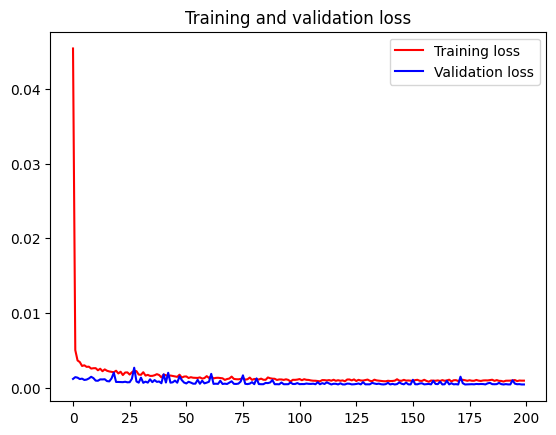

<Figure size 640x480 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [76]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)

test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

6/6 [==============================] - 0s 10ms/step


((1069, 1), (176, 1))

### Model Evaluation - Transform back the data (i.e. Inverse Scaling)

In [77]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


<!-- ### Explained variance regression score -->

<!-- ### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD) -->


### Comparison of original stock close price and predicted open price


In [84]:
# shift train predictions for plotting the look-ahead time for predicted stock values

# First delete the 'date' column from below df to make it a single column df
# so that train_predict_look_ahead variable can be properly structured
# del stock_df_open_last_1_year['date']

look_back=time_step

train_predict_look_ahead = np.empty_like(stock_df_open_last_1_year)

train_predict_look_ahead[:, :] = np.nan

# For looking ahead by look_back, I need to start at look_back
train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

####################### TEST #############################
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_open_last_1_year)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_open_last_1_year)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])


plotdf = pd.DataFrame({'date': stock_df_open_last_1_year_original_gt['date'],
                       'original_open': stock_df_open_last_1_year_original_gt['open'],
                      'train_predicted_open': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='open Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1277, 1)
Test predicted data:  (1277, 1)


## Evaluating the model
### Showing the closeness of predicted value and actual value

In [79]:



# print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))

# print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))


print("Root Mean Square Error: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))


print("Mean Absolute Error: ", mean_absolute_error(original_ytest,test_predict))

Root Mean Square Error:  5.242770602679294
Mean Absolute Error:  4.097130077642268


### Showing the variance in the Target variable

In [80]:
# R-squared to show how well the model fits the data
# print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("R2 score:", r2_score(original_ytest, test_predict))

R2 score: 0.9039247564053038


In [81]:
# Calculate MSE
# print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("'Mean Squared Error:' ", mean_squared_error(original_ytest,test_predict))


'Mean Squared Error:'  27.486643592318213


In [82]:
# Calculate RMSE
# print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Root Mean Squared Error : ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

Root Mean Squared Error :  5.242770602679294
